In [1]:
%pylab inline
import sys 
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sympy import *
from gplearn.fitness import make_fitness

Populating the interactive namespace from numpy and matplotlib


## Import features dataset and clean it

In [2]:
data_raw = pd.read_pickle('../Feature_extraction/Save_extractions/4b_7f.pkl')

# CHOOSE TWO CLASSES TO CLASSIFY
class1 = 90 
class2 = 42

# CHOOSE THE NUMBER OF OBJECTS FOR EACH CLASS
nb1 = 1000
nb2 = 1000


data_flitered = data_raw[(data_raw['TARGET']==class1) | (data_raw['TARGET']==class2)]

mask1 = data_flitered['TARGET'] == class1
mask2 = data_flitered['TARGET'] == class2

data1 = data_flitered[mask1]
data2 = data_flitered[mask2]

data1_final = data1.sample(n=nb1, replace=False)
data2_final = data2.sample(n=nb2, replace=False)
data = pd.concat([data1_final,data2_final], ignore_index=True)

all_features = data.iloc[:,1:(shape(data)[1]-1)]
all_classes = np.array(data['TARGET'])
unique_classes = np.unique(list(all_classes))

# Print the shape of the final data
all_features.head()

,amplitude2,chi22,beyond_1_std2,mean_variance2,skew2,kurtosis2,stetson_K2,amplitude3,chi23,beyond_1_std3,...,skew4,kurtosis4,stetson_K4,amplitude5,chi25,beyond_1_std5,mean_variance5,skew5,kurtosis5,stetson_K5
0,0.196858,14.370456,0.400000,0.126676,0.036015,-0.519895,0.787608,0.268516,24.132816,0.250000,...,-1.484557,2.165711,0.784260,0.407037,2.586354,0.250000,0.239157,-1.129779,0.943346,0.817329
1,4.717284,424.865397,0.428571,0.530384,-0.391879,-0.708016,0.858922,1.448352,148.381081,0.166667,...,-1.825414,3.510874,0.770373,0.783713,7.643030,0.333333,0.279077,-1.316356,1.936522,0.802490
2,7.355387,1204.029444,0.214286,0.858759,0.761612,-0.883439,0.841027,3.654809,399.979773,0.357143,...,0.679263,-0.807672,0.808626,1.243842,20.134790,0.384615,0.411772,0.611536,-1.190300,0.797097
3,9.424825,802.552905,0.222222,1.062897,1.292508,0.321163,0.804551,3.372073,325.629774,0.181818,...,0.471448,-0.614107,0.831511,0.592386,12.412906,0.166667,0.320391,0.810002,-0.720938,0.806556
4,3.374771,427.644985,0.400000,0.654977,0.202386,-2.281300,0.795640,1.452499,139.653102,0.666667,...,0.908669,-0.177441,0.843306,0.765720,8.969542,0.333333,0.427563,0.816377,-1.579769,0.884923


### Choose a subset of features :

In [3]:
feature_tochoose = [*all_features.columns]
features = all_features.loc[:,feature_tochoose]

### Choose an attractor goal value for each type of object

In [4]:
goal1 = 10
goal2 = -10


# AUTO CREATE A DICTIONARY
dic_classes = {class1:goal1, class2:goal2}
dic_classes

{90: 10, 42: -10}

### Build training and testing sample

In [5]:
# Then split it into train and test samples
X_train, X_test, y_train, y_test = train_test_split(features, data['TARGET'], test_size=0.30, random_state=42)

## Evolve towards ideal function

In [6]:
#Import evolution scripts
sys.path.append(os.path.abspath('../Scripts'))
from create_model import *

### Define a custom cost function

In [7]:
def _mape(y, y_pred, w):
    
    diffs = (np.abs(y - y_pred))**2
    return 100. * np.average(diffs, weights=w)

mape = make_fitness(_mape, greater_is_better=False)

### Choose the parameters 

In [8]:
features = X_train
classes = y_train

save = 'Model_saves/tournament_test'
population_size=700
generations=500
metric = mape

p_crossover=0.6
p_subtree_mutation=0.2
p_hoist_mutation=0.05
p_point_mutation=0.1
tournament_size = 400
n_jobs = 1
parsimony_coefficient = 7

### Create your function

In [9]:
#GENERATE A MODEL
model = evolve(features, classes, dic_classes, save, population_size=population_size, generations=generations,metric=mape,tournament_size =tournament_size, n_jobs=n_jobs, parsimony_coefficient=parsimony_coefficient)

#OR LOAD A PREVIOUS MODEL
#model = pd.read_pickle('Model_saves/tournament_test.pkl')

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0     8.63      1.13052e+15        3          9713.79          9687.55      3.18m
   1     3.69      2.01082e+14        6           9486.2          9540.21      3.99m
   2     5.47      5.32704e+12        8             9285          9882.53      3.98m
   3     8.09      4.45514e+06       14          9002.34          9551.26      4.13m
   4    13.25      3.62065e+12       18          8821.31          10342.3      4.46m
   5    18.25      2.66742e+13       20          8730.27          9852.86      5.31m
   6    19.61       1.0104e+07       28          8593.39          8435.11      4.97m
   7    25.29      9.98883e+07       29          8426.13          8568.06      5.36m
   8    28.82      1.12858e+08       51          8061.25          8511.18  

NB : A save of this function is created in a .pkl file

## Analyse the performance of the model

In [10]:
# Import the plotting scripts
sys.path.append(os.path.abspath('../Scripts'))
from plot import *

### Choose parameters

In [11]:
# For the dictionary, we simply reverse the previous one
dic_goals = {v: k for k, v in dic_classes.items()}

function = model
classes = y_test
features = X_test

### Scatter plots :

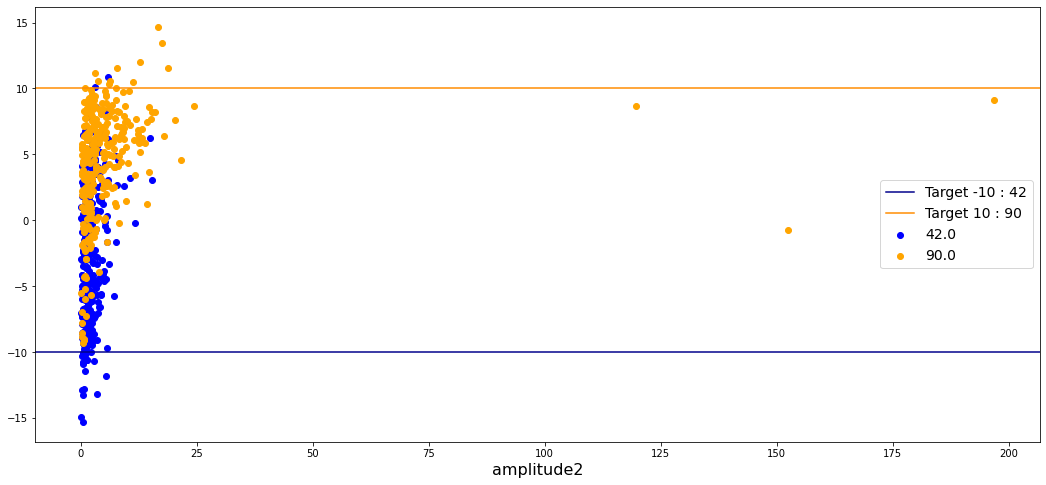

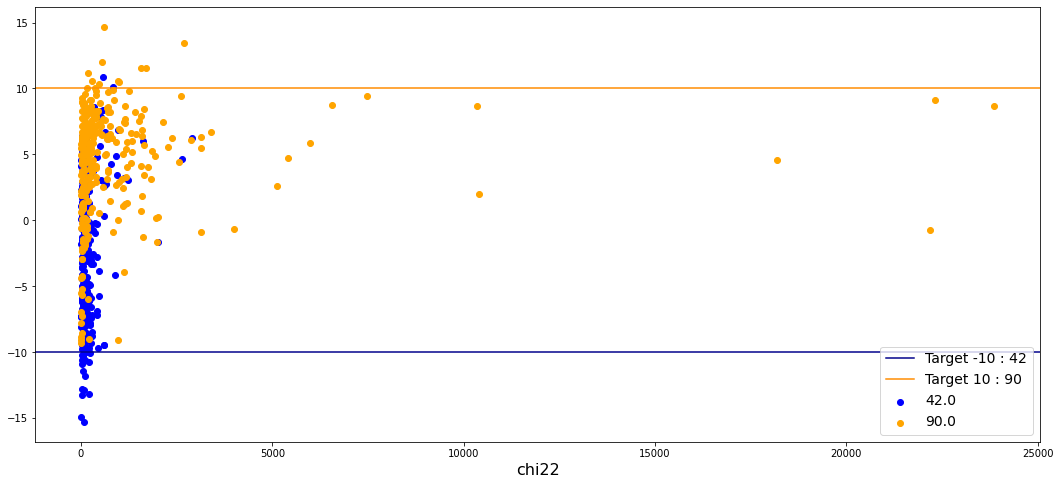

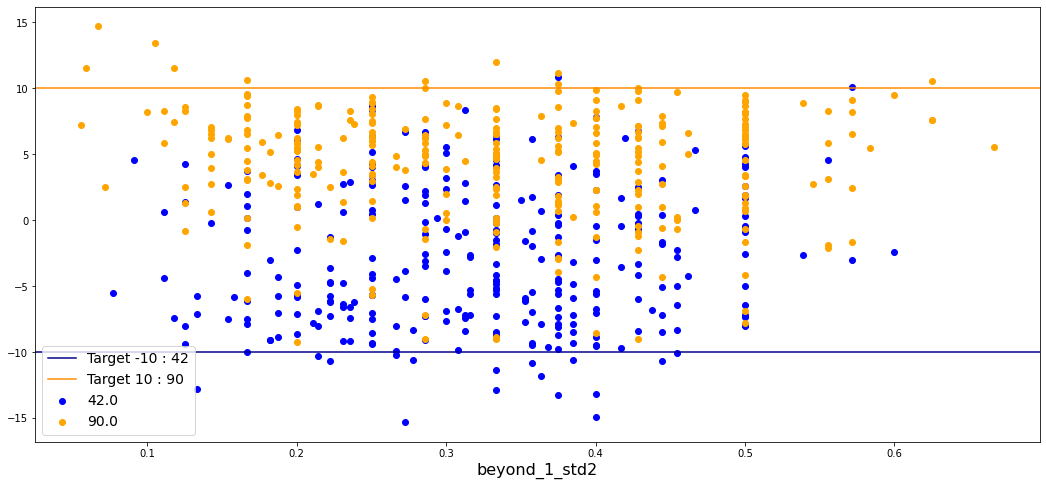

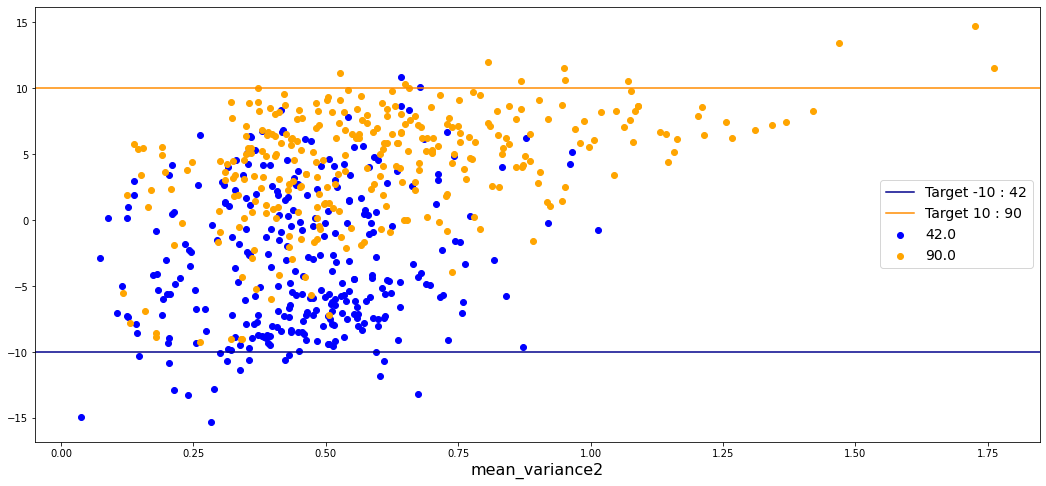

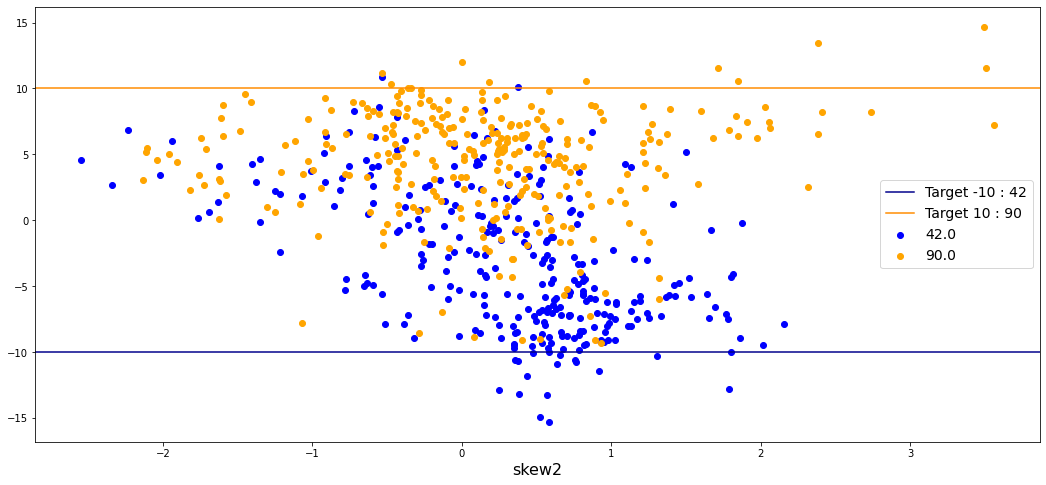

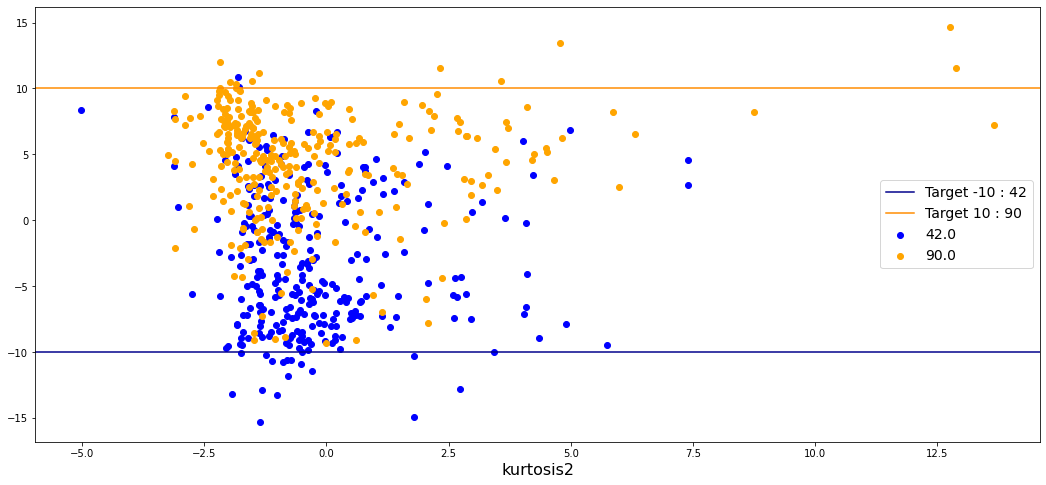

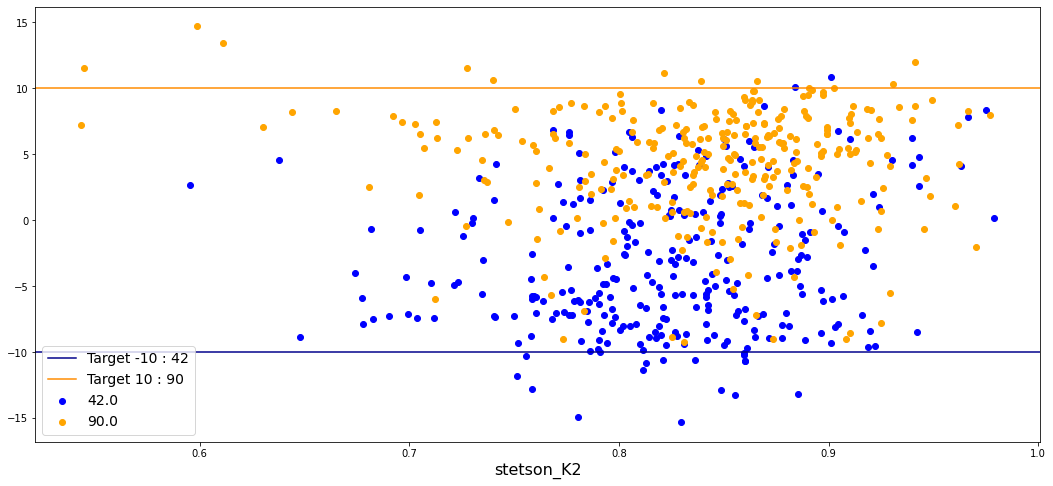

In [12]:
for i in feature_tochoose[0:7]:

    plt.figure(figsize=(18,8))
    plt.xlabel(i,size = 16)
    scatter_plot(function,features,i,dic_goals,classes=classes)
    plt.legend(fontsize = 14)

### Histogram plot :

In [13]:
PISN = data_raw[data_raw['TARGET']==994]
PISN_feature = PISN.iloc[:,1:(shape(data)[1]-1)]
PISN_resultat = model.predict(PISN_feature)
PISN_resultat

array([ 7.55857488, -1.29243024,  2.09314913])

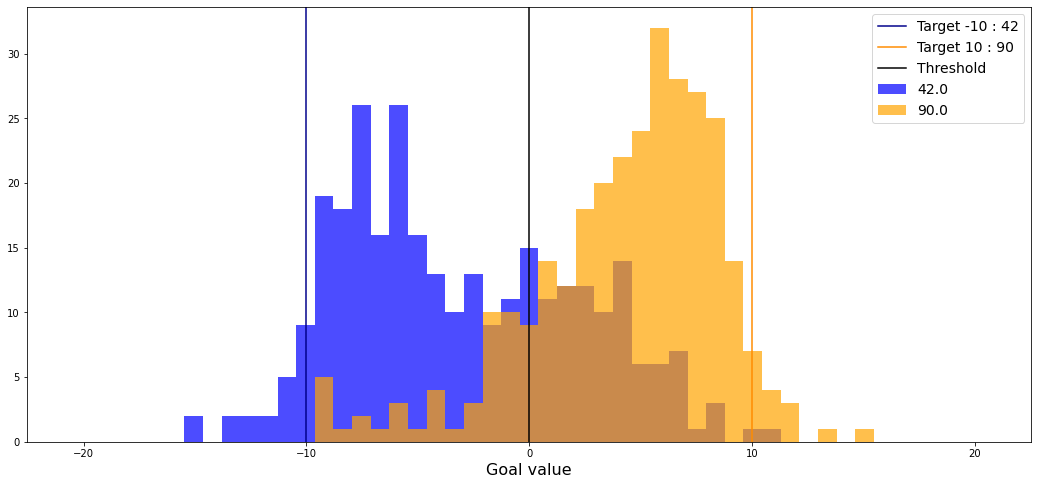

In [14]:
thresh=0
bins = np.linspace(-20.5,20.5,50)

plt.figure(figsize=(18,8))
plt.xlabel('Goal value',size = 16)
histo_plot(function,features,dic_goals,bins,classes = classes, alpha = 0.7, thresh = thresh)
plt.legend(fontsize = 14)

In [15]:

resultat = model.predict(X_test)
prediction = resultat.copy()
prediction[resultat>thresh] = class1
prediction[resultat<=thresh] = class2
accuracy = (prediction == y_test).sum()*100/len(prediction)

print('Le percent of good answers with a threshold to %s is : %s'%(thresh,accuracy))

Le percent of good answers with a threshold to 0 is : 77.66666666666667


In [16]:
# Print the mathematical equation of the function
sympify((str(model._program)), locals=converter)

10*mean_variance3 - 2*skew2 - skew3 - cos(kurtosis3) - cos(kurtosis2 - 2*mean_variance3 + skew2) - cos(2*mean_variance3 - skew2 + mean_variance3/beyond_1_std3) - 2*cos(mean_variance3 - skew2 - skew3 + mean_variance3/beyond_1_std3) - cos(2*mean_variance3 - skew2 - cos(2*mean_variance3 - skew2 + mean_variance3/beyond_1_std3) + mean_variance3/beyond_1_std3) - 3/(beyond_1_std3 + mean_variance3) + mean_variance3/beyond_1_std3